In [1]:
import kiwigrad
kiwigrad.__version__

'0.27'

In [2]:
from sklearn.datasets import make_regression
from kiwigrad import MLP, Layer, Value, draw_dot
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time
%matplotlib inline

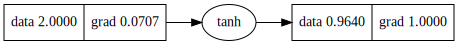

In [12]:
a = Value(2.)
b = a.tanh()
b.backward()
draw_dot(b)

In [13]:
print(a.grad)

0.07065082485316443


In [10]:
import torch
a = torch.tensor([2.], requires_grad=True)
b = a.tanh()
b.backward()
print(a.grad)

tensor([0.0707])


In [3]:
X, y = make_regression(n_samples=200, n_features=5, n_targets=1, random_state=42)
print(X.shape)
print(y.shape)
print(X[0])
print(y[0:5])

(200, 5)
(200,)
[0.95927083 0.02451017 0.49799829 1.45114361 2.15318246]
[172.54436082 -52.9529574   -4.14935233 193.99958991 -66.96262773]


In [4]:
inputs = [[Value(i) for i in elem] for elem in X]
inputs[0]

[Value(data=0.959271, grad=0.000000),
 Value(data=0.024510, grad=0.000000),
 Value(data=0.497998, grad=0.000000),
 Value(data=1.451144, grad=0.000000),
 Value(data=2.153182, grad=0.000000)]

In [5]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=5, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=1, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()
y_pred = model(inputs[0])
print(y_pred)

Value(data=2.668012, grad=0.000000)


In [6]:
epochs = 100
for epoch in range(epochs):
    y_pred = []
    s = time.monotonic()
    for i in range(len(inputs)):
        output = model(inputs[i])
        y_pred.append(output.data)
        target = Value(y[i])
        loss = output - target
        loss_e = loss * loss
        loss_e.backward()
        for p in model.parameters():
            p.data += -0.0001 * p.grad
        model.zero_grad()
    e = time.monotonic()
    t = e - s
    if epoch % 10 == 0:
        print(f"epoch: {epoch} | loss: {loss_e.data:.2f} | time: {t:.2f} sec.")

epoch: 0 | loss: 194.88 | time: 0.12 sec.
epoch: 10 | loss: 0.09 | time: 0.09 sec.
epoch: 20 | loss: 0.58 | time: 0.07 sec.
epoch: 30 | loss: 1.40 | time: 0.07 sec.
epoch: 40 | loss: 1.75 | time: 0.07 sec.
epoch: 50 | loss: 1.59 | time: 0.07 sec.
epoch: 60 | loss: 1.40 | time: 0.07 sec.
epoch: 70 | loss: 1.29 | time: 0.07 sec.
epoch: 80 | loss: 1.04 | time: 0.07 sec.
epoch: 90 | loss: 0.88 | time: 0.07 sec.


In [7]:
r2 = r2_score(y, y_pred)
r2

0.9999600351603299

In [8]:
idx = 3
print(y[idx], y_pred[idx])

193.99958991165147 193.96765578073223


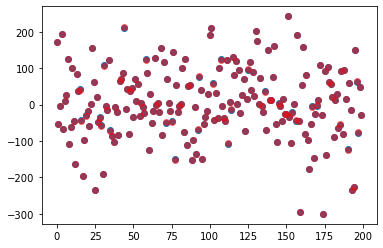

In [16]:
x = [i for i in range(len(inputs))]
plt.scatter(x, y)
plt.scatter(x, y_pred, color='red', alpha=0.5)
plt.show()

## arch

In [ ]:
epochs = 200
lr = 0.001
for epoch in range(epochs):
    s = time.monotonic()
    for i in range(len(inputs)):
        forward = model(inputs[i])
        exp_forward = [elem.exp() for _, elem in enumerate(forward)]
        norm_term = Value(0.)
        for _, elem in enumerate(exp_forward):
            norm_term = norm_term + elem
        softmax_vec = [elem / norm_term for _, elem in enumerate(exp_forward)]
        bce_losses = []
        for j in range(len(softmax_vec)):
            output = softmax_vec[j]
            target = Value(y_train_ohe[i][j])
            neg_output = Value(1.) - softmax_vec[j]
            bce_loss = -(target * output.log() + (Value(1)-target)*neg_output.log())
            bce_losses.append(bce_loss)
        BCEloss = Value(0.)
        for _, single_loss in enumerate(bce_losses):
            BCEloss = BCEloss + single_loss
        BCEloss.backward()
        for p in model.parameters():
            p.data += -lr * p.grad
        model.zero_grad()
    e = time.monotonic()
    t = e - s
    if epoch % 10 == 0:
        print(f"epoch: {epoch} | loss: {BCEloss.data:.2f} | time: {t:.2f} sec.")